In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100

import os
from neo4j import GraphDatabase
from dotenv import load_dotenv

load_dotenv(override=True)

NEO4J_USERNAME = os.getenv("NEO4J_USER","neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD","neo4j")
NEO4J_URI= os.getenv("NEO4J_URI","bolt://localhost:7687")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

In [2]:
pokemon = pd.read_parquet("../data/pokemonDB_dataset.parquet")

In [4]:
def clear_neo4j_database(driver):
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")

# Clear the Neo4j database
clear_neo4j_database(driver)

In [3]:
pokemon.query("Pokemon.isin(['Pikachu','Partner Pikachu'])")

,Pokemon,Type,Species,Height,Weight,Abilities,EV Yield,Catch Rate,Base Friendship,Base Exp,Growth Rate,Egg Groups,Gender,Egg Cycles,HP Base,HP Min,HP Max,Attack Base,Attack Min,Attack Max,Defense Base,Defense Min,Defense Max,Special Attack Base,Special Attack Min,Special Attack Max,Special Defense Base,Special Defense Min,Special Defense Max,Speed Base,Speed Min,Speed Max,Description,vectorProperty
782,Pikachu,Electric,Mouse Pokémon,0.4,6.0,"1. Static, Lightning Rod (hidden ability)",2 Speed,"190 (24.8% with PokéBall, full HP)",50 (normal),112,Medium Fast,"Fairy, Field","50% male, 50% female","10 (2,314–2,570 steps)",35,180,274,55,103,229,40,76,196,50,94,218,50,94,218,90,166,306,"{""Pokemon"":""Pikachu"",""Type"":""Electric"",""Species"":""Mouse Pok\u00e9mon"",""Height"":0.4,""Weight"":6.0,...","[-0.0007957454, -0.084871136, 0.007021067, -0.0038773876, -0.03755728, -0.015589074, -0.00457919..."
783,Partner Pikachu,Electric,Mouse Pokémon,0.4,6.0,—,2 Speed,"190 (24.8% with PokéBall, full HP)",50 (normal),112,Medium Fast,—,"50% male, 50% female","10 (2,314–2,570 steps)",45,200,294,80,148,284,50,94,218,75,139,273,60,112,240,120,220,372,"{""Pokemon"":""Partner Pikachu"",""Type"":""Electric"",""Species"":""Mouse Pok\u00e9mon"",""Height"":0.4,""Weig...","[0.013860259, -0.06465123, 0.02431766, -3.475531e-05, -0.041567996, -0.017187022, -0.009548702, ..."


### Pokemon

In [6]:
def insert_pokemon_data(tx, row):
    
    query = """
    MERGE (p:Pokemon {name: $pokemon})
    SET p.height = $height,
        p.weight = $weight,
        p.ev_yield = $ev_yield,
        p.catch_rate = $catch_rate,
        p.base_friendship = $base_friendship,
        p.base_exp = $base_exp,
        p.growth_rate = $growth_rate,
        p.egg_cycles = $egg_cycles,
        p.hp_base = $hp_base,
        p.hp_min = $hp_min,
        p.hp_max = $hp_max,
        p.attack_base = $attack_base,
        p.attack_min = $attack_min,
        p.attack_max = $attack_max,
        p.defense_base = $defense_base,
        p.defense_min = $defense_min,
        p.defense_max = $defense_max,
        p.special_attack_base = $special_attack_base,
        p.special_attack_min = $special_attack_min,
        p.special_attack_max = $special_attack_max,
        p.special_defense_base = $special_defense_base,
        p.special_defense_min = $special_defense_min,
        p.special_defense_max = $special_defense_max,
        p.speed_min = $speed_min,
        p.speed_max = $speed_max,
        p.description = $description,
        p.vector_property=$vector_property
    """
    tx.run(query, 
           pokemon=row['Pokemon'], 
           height=row['Height'], 
           weight=row['Weight'], 
           ev_yield=row['EV Yield'], 
           catch_rate=row['Catch Rate'], 
           base_friendship=row['Base Friendship'], 
           base_exp=row['Base Exp'], 
           growth_rate=row['Growth Rate'], 
           egg_cycles=row['Egg Cycles'], 
           hp_base=row['HP Base'], 
           hp_min=row['HP Min'], 
           hp_max=row['HP Max'], 
           attack_base=row['Attack Base'], 
           attack_min=row['Attack Min'], 
           attack_max=row['Attack Max'], 
           defense_base=row['Defense Base'], 
           defense_min=row['Defense Min'], 
           defense_max=row['Defense Max'], 

           special_attack_base=row['Special Attack Base'], 
           special_attack_min=row['Special Attack Min'],
           special_attack_max=row['Special Attack Max'],
           special_defense_base=row['Special Defense Base'],
           special_defense_min=row['Special Defense Min'],
           special_defense_max=row['Special Defense Max'],

           speed_min=row['Speed Min'], 
           speed_max=row['Speed Max'],
           description=row['Description'],
           vector_property=row['vectorProperty']
           )

# Insert data into Neo4j
with driver.session() as session:
    for index, row in pokemon.iterrows():
        session.execute_write(insert_pokemon_data, row)


### Pokemon -> Egg Group


In [7]:
pokemon_egg_groups = pokemon['Egg Groups'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
pokemon_expanded_egg_groups = pokemon.drop('Egg Groups', axis=1).join(pokemon_egg_groups.rename('Egg Group'))

def insert_egg_group_data(tx, pokemon, egg_group):
    query = """
    MATCH (p:Pokemon {name: $pokemon})
    MERGE (e:EggGroup {name: $egg_group})
    MERGE (p)-[:HAS_GENETIC_TIE]->(e)
    """
    tx.run(query, pokemon=pokemon, egg_group=egg_group)

# Insert egg group data into Neo4j
with driver.session() as session:
    for index, row in pokemon_expanded_egg_groups.iterrows():
        session.execute_write(insert_egg_group_data, row['Pokemon'], row['Egg Group'])

### Pokemon -> Gender

In [8]:
pokemon_genders = pokemon['Gender'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
pokemon_expanded_genders = pokemon.drop('Gender', axis=1).join(pokemon_genders.rename('Gender'))

def insert_gender_data(tx, pokemon, gender):
    query = """
    MATCH (p:Pokemon {name: $pokemon})
    MERGE (g:Gender {name: $gender})
    MERGE (p)-[:HAS_GENDER]->(g)
    """
    tx.run(query, pokemon=pokemon, gender=gender)

# Insert gender data into Neo4j
with driver.session() as session:
    for index, row in pokemon_expanded_genders.iterrows():
        session.execute_write(insert_gender_data, row['Pokemon'], row['Gender'])


### Pokemon -> Abilities

In [9]:
pokemon_abilities = pokemon['Abilities'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
pokemon_abilities = pokemon_abilities.str.replace(r'^\d+\.\s*', '', regex=True)
pokemon_expanded_abilities = pokemon.drop('Abilities', axis=1).join(pokemon_abilities.rename('Ability'))

def insert_ability_data(tx, pokemon, ability):
    query = """
    MATCH (p:Pokemon {name: $pokemon})
    MERGE (a:Ability {name: $ability})
    MERGE (p)-[:HAS_ABILITY]->(a)
    """
    tx.run(query, pokemon=pokemon, ability=ability)

# Insert ability data into Neo4j
with driver.session() as session:
    for index, row in pokemon_expanded_abilities.filter(['Pokemon', 'Ability']).iterrows():
        session.execute_write(insert_ability_data, row['Pokemon'], row['Ability'])

### Pokemon -> Species

In [10]:
pokemon['Species'] = pokemon['Species'].str.replace(' Pokémon', '')
species_df = pokemon.filter(['Species']).drop_duplicates()

# Define a function to insert species data into Neo4j
def insert_species_data(tx, species):
    query = """
    MERGE (s:Species {name: $species})
    """
    tx.run(query, species=species)

# Insert species data into Neo4j
with driver.session() as session:
    for index, row in species_df.iterrows():
        session.execute_write(insert_species_data, row['Species'])

### Species -> Type

In [11]:
pokemon_types = pokemon['Type'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
pokemon_expanded = pokemon.drop('Type', axis=1).join(pokemon_types.rename('Type'))

def insert_species_type_data(tx, species, pokemon):
    query = """
    MATCH (s:Species {name: $species})
    MERGE (p:Pokemon {name: $pokemon})
    MERGE (p)-[:BELONGS_TO]->(s)
    """
    tx.run(query, species=species, pokemon=pokemon)

def insert_pokemon_type_data(tx, pokemon, type_):
    query = """
    MATCH (p:Pokemon {name: $pokemon})
    MERGE (t:Type {name: $type_})
    MERGE (p)-[:HAS_TYPE]->(t)
    """
    tx.run(query, pokemon=pokemon, type_=type_)

# Insert species, type, and pokemon-type data into Neo4j
with driver.session() as session:
    for index, row in pokemon_expanded.filter(['Species', 'Type', 'Pokemon']).iterrows():
        session.execute_write(insert_species_type_data, row['Species'], row['Pokemon'])
        session.execute_write(insert_pokemon_type_data, row['Pokemon'], row['Type'])


In [ ]:
# Query the type and species of Pikachu from Neo4j
def query_pikachu_type_and_species(tx):
    query = """
    MATCH (p:Pokemon {name: 'Pikachu'})-[:HAS_TYPE]->(t:Type),
          (p)-[:BELONGS_TO]->(s:Species)
    RETURN t.name AS Type, s.name AS Species
    """
    result = tx.run(query)
    return result.single()

# Execute the query and print the result
with driver.session() as session:
    pikachu_data = session.execute_read(query_pikachu_type_and_species)
    if pikachu_data:
        print(f"Pikachu Type: {pikachu_data['Type']}, Species: {pikachu_data['Species']}")
    else:
        print("Pikachu data not found.")

In [7]:
pokemon['PokemonFile'] = pokemon['Pokemon'].str.replace(' ', '_')
pokemon.head()

,Pokemon,Type,Species,Height,Weight,Abilities,EV Yield,Catch Rate,Base Friendship,Base Exp,Growth Rate,Egg Groups,Gender,Egg Cycles,HP Base,HP Min,HP Max,Attack Base,Attack Min,Attack Max,Defense Base,Defense Min,Defense Max,Special Attack Base,Special Attack Min,Special Attack Max,Special Defense Base,Special Defense Min,Special Defense Max,Speed Base,Speed Min,Speed Max,Description,vectorProperty,PokemonFile
0,Abomasnow,"Grass, Ice",Frost Tree Pokémon,2.2,135.5,"1. Snow Warning, Soundproof (hidden ability)","1 Attack, 1 Sp. Atk","60 (7.8% with PokéBall, full HP)",50 (normal),173,Slow,"Grass, Monster","50% male, 50% female","20 (4,884–5,140 steps)",90,290,384,92,170,311,75,139,273,92,170,311,85,157,295,60,112,240,"{""Pokemon"":""Abomasnow"",""Type"":""Grass, Ice"",""Species"":""Frost Tree Pok\u00e9mon"",""Height"":2.2,""Wei...","[-0.0011539825, -0.066864446, -0.002493589, -0.009149691, -0.03286393, -0.0100959875, -0.0373166...",Abomasnow
1,Mega Abomasnow,"Grass, Ice",Frost Tree Pokémon,2.7,185.0,1. Snow Warning,"1 Attack, 1 Sp. Atk","60 (7.8% with PokéBall, full HP)",50 (normal),208,Slow,"Grass, Monster","50% male, 50% female","20 (4,884–5,140 steps)",90,290,384,132,242,399,105,193,339,132,242,399,105,193,339,30,58,174,"{""Pokemon"":""Mega Abomasnow"",""Type"":""Grass, Ice"",""Species"":""Frost Tree Pok\u00e9mon"",""Height"":2.7...","[-0.011688934, -0.063620225, 0.004530833, -0.008508488, -0.03436005, -0.014271023, -0.029623868,...",Mega_Abomasnow
2,Abra,Psychic,Psi Pokémon,0.9,19.5,"1. Synchronize, 2. Inner Focus, Magic Guard (hidden ability)",1 Sp. Atk,"200 (26.1% with PokéBall, full HP)",50 (normal),62,Medium Slow,Human-Like,"75% male, 25% female","20 (4,884–5,140 steps)",25,160,254,20,40,152,15,31,141,105,193,339,55,103,229,90,166,306,"{""Pokemon"":""Abra"",""Type"":""Psychic"",""Species"":""Psi Pok\u00e9mon"",""Height"":0.9,""Weight"":19.5,""Abil...","[0.006291091, -0.06717928, -0.0054227714, -0.00661571, -0.035259947, -0.015229812, -0.0488578, -...",Abra
3,Absol,Dark,Disaster Pokémon,1.2,47.0,"1. Pressure, 2. Super Luck, Justified (hidden ability)",2 Attack,"30 (3.9% with PokéBall, full HP)",35 (lower than normal),163,Medium Slow,Field,"50% male, 50% female","25 (6,169–6,425 steps)",65,240,334,130,238,394,60,112,240,75,139,273,60,112,240,75,139,273,"{""Pokemon"":""Absol"",""Type"":""Dark"",""Species"":""Disaster Pok\u00e9mon"",""Height"":1.2,""Weight"":47.0,""A...","[-0.010993939, -0.070585206, 0.0012146243, 0.00077470584, -0.027102279, -0.023860883, -0.0337015...",Absol
4,Mega Absol,Dark,Disaster Pokémon,1.2,49.0,1. Magic Bounce,2 Attack,"30 (3.9% with PokéBall, full HP)",35 (lower than normal),198,Medium Slow,Field,"50% male, 50% female","25 (6,169–6,425 steps)",65,240,334,150,274,438,60,112,240,115,211,361,60,112,240,115,211,361,"{""Pokemon"":""Mega Absol"",""Type"":""Dark"",""Species"":""Disaster Pok\u00e9mon"",""Height"":1.2,""Weight"":49...","[-0.016683957, -0.06085115, 0.008552488, 0.0009983473, -0.03368261, -0.020433808, -0.027487688, ...",Mega_Absol


### IMAGE EMBEDDINGS

In [36]:
# from torchvision import transforms
# from PIL import Image

# import torch
# import torchvision.models as models
# from torchvision.models import ResNet152_Weights

# # Load pretrained ResNet152 model
# model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2, progress=True)

# # Remove the final fully-connected layer
# model = torch.nn.Sequential(*(list(model.children())[:-1]))

# # Set the model to evaluation mode
# model.eval()

# # Define preprocessing steps
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize all images to 224x224
#     transforms.ToTensor(),
# ])

# # Define a function to extract embeddings for each Pokemon
# def extract_embeddings_for_pokemon(pokemon_name):

#     try:
#         image_path = f"../data/pokemon_db/images/{pokemon_name}/{pokemon_name}_new.png"

#         image = Image.open(image_path).convert('RGB')
#         input_tensor = preprocess(image).unsqueeze(0)
        
#         # Extract embeddings
#         with torch.no_grad():
#             embeddings = model(input_tensor)
        
#         # Reshape embeddings to a 1D vector
#         return embeddings.squeeze().numpy()
#     except FileNotFoundError:
#         print(f"Image not found for {pokemon_name}. Continuing to next.")
#         return None
    

# pokemon_name = "Pikachu"
# pikachu = extract_embeddings_for_pokemon(pokemon_name)


# pokemon_name = "Partner_Pikachu"
# pikachu2 = extract_embeddings_for_pokemon(pokemon_name)

# # INSERT_YOUR_CODE
# import torch

# def cosine_similarity_torch(vec1, vec2):
#     vec1 = torch.tensor(vec1)
#     vec2 = torch.tensor(vec2)
#     return torch.nn.functional.cosine_similarity(vec1, vec2, dim=0).item()

# # Calculate cosine similarity between Pikachu and Partner Pikachu using PyTorch
# similarity = cosine_similarity_torch(pikachu, pikachu2)
# print(f"Cosine similarity between Pikachu and Partner Pikachu: {similarity}")


# pokemon_name = "Pawmot"
# Pawmot = extract_embeddings_for_pokemon(pokemon_name)

# similarity = cosine_similarity_torch(pikachu, Pawmot)
# print(f"Cosine similarity between Pikachu and Pawmot: {similarity}")


# pokemon_name = "Raichu"
# raichu = extract_embeddings_for_pokemon(pokemon_name)

# similarity = cosine_similarity_torch(pikachu, raichu)
# print(f"Cosine similarity between Pikachu and Raichu: {similarity}")


In [41]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

def extract_image_embedding(pokemon_name):
    image_path = f"../data/pokemon_db/images/{pokemon_name}/{pokemon_name}_new.png"
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt", padding=True)
        
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        
        # Normalize the embedding
        embedding = outputs.squeeze()
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
        return embedding.tolist()
    except FileNotFoundError:
        print(f"Image not found for {pokemon_name}. Continuing to next.")
        return None
    

In [42]:

def insert_embeddings(tx, pokemon_name, embeddings):
    # Create a Cypher query to insert embeddings
    query = """
    MERGE (p:Pokemon {name: $pokemon_name})
    SET p.resnet152_embeddings = $embeddings
    """
    # Execute the query with the provided parameters
    tx.run(query, pokemon_name=pokemon_name, embeddings=embeddings)

for index, row in pokemon.iterrows():
    pokemon_name = row['Pokemon']
    pokemon_file = row['PokemonFile']

    embeddings = extract_image_embedding(pokemon_file)
    
    if embeddings is not None:
        with driver.session() as session:
            session.execute_write(insert_embeddings, pokemon_name, embeddings)

Image not found for Castform_Sunny_Form. Continuing to next.
Image not found for Castform_Rainy_Form. Continuing to next.
Image not found for Castform_Snowy_Form. Continuing to next.
Image not found for Dudunsparce_Three-Segment_Form. Continuing to next.
Image not found for Partner_Eevee. Continuing to next.
Image not found for Eternatus_Eternamax. Continuing to next.
Image not found for Farfetch'd. Continuing to next.
Image not found for Galarian_Farfetch'd. Continuing to next.
Image not found for Gouging_Fire. Continuing to next.
Image not found for Gourgeist_Average_Size. Continuing to next.
Image not found for Gourgeist_Small_Size. Continuing to next.
Image not found for Gourgeist_Large_Size. Continuing to next.
Image not found for Gourgeist_Super_Size. Continuing to next.
Image not found for Ash-Greninja. Continuing to next.
Image not found for Hoopa_Confined. Continuing to next.
Image not found for Hoopa_Unbound. Continuing to next.
Image not found for Hydrapple. Continuing to ne

In [47]:
# INSERT_YOUR_CODE
def query_similar_pokemon(tx, target_embeddings, threshold=0.7):
    # Create a Cypher query to find similar Pokemon based on embeddings
    query = """
    MATCH (p:Pokemon)
    WHERE p.resnet152_embeddings IS NOT NULL AND size(p.resnet152_embeddings) > 0
    WITH p, gds.similarity.cosine(p.resnet152_embeddings, $target_embeddings) as cosineSimilarity
    WHERE cosineSimilarity > $threshold
    RETURN p.name AS name, cosineSimilarity
    ORDER BY cosineSimilarity DESC
    """
    # Execute the query with the provided parameters
    result = tx.run(query, target_embeddings=target_embeddings, threshold=threshold)
    return [(record["name"], record["cosineSimilarity"]) for record in result]

In [48]:
embeddings = extract_image_embedding("Pikachu")
embeddings

[0.0464036725461483,
 -0.014609254896640778,
 -0.02246900089085102,
 0.026997974142432213,
 0.021515557542443275,
 -0.02261442318558693,
 0.04132787138223648,
 0.057924896478652954,
 0.009720252826809883,
 -0.006363844033330679,
 0.054148297756910324,
 -0.05242260545492172,
 0.03510361537337303,
 -0.0029368067625910044,
 0.051863331347703934,
 0.011690938845276833,
 0.02358860708773136,
 0.01369056198745966,
 -0.0004878770560026169,
 -0.0028717280365526676,
 -0.041957322508096695,
 -0.033679600805044174,
 0.02140173874795437,
 0.002195933135226369,
 -0.017299151048064232,
 0.010340627282857895,
 -0.01884075440466404,
 0.01952824927866459,
 -0.017045918852090836,
 -0.005982997361570597,
 0.024941517040133476,
 0.013335601426661015,
 0.007961317896842957,
 0.004899871535599232,
 0.018725814297795296,
 0.008119250647723675,
 -0.030876461416482925,
 0.014443280175328255,
 0.024630887433886528,
 0.06576181203126907,
 -0.009838279336690903,
 -0.03942960873246193,
 0.002357401652261615,
 -0.0

Pokemon: Pikachu, Similarity: 1.0
Pokemon: Partner Pikachu, Similarity: 0.9797078524892616
Pokemon: Plusle, Similarity: 0.9527996270782402
Pokemon: Pichu, Similarity: 0.9473967847882055
Pokemon: Minun, Similarity: 0.9413983115662855


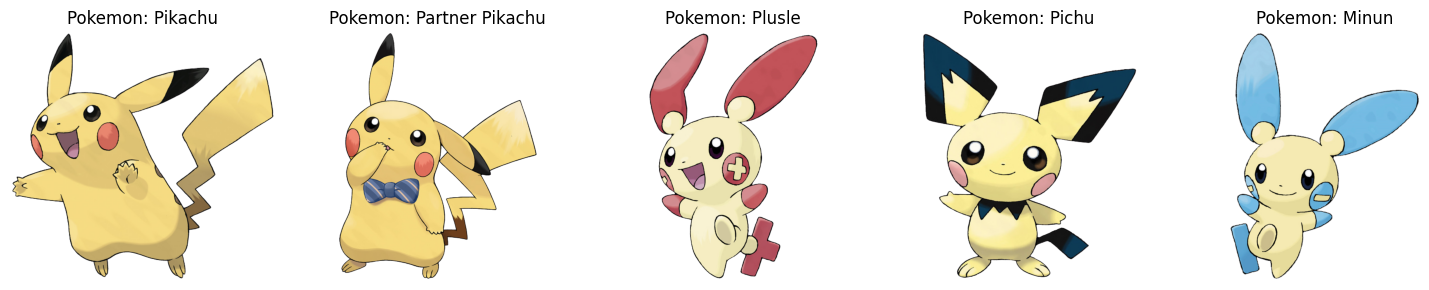

In [55]:
# Use the driver to open a session and query for similar Pokemon
with driver.session() as session:
    similar_pokemon = session.execute_write(query_similar_pokemon, embeddings, 0.94)

# Print the similar Pokemon}
for name, cosineSimilarity in similar_pokemon:
    print(f"Pokemon: {name}, Similarity: {cosineSimilarity}")

# INSERT_YOUR_CODE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# INSERT_YOUR_REWRITE_HERE

def show_similar_pokemon_images(similar_pokemon, image_folder="path_to_images"):
    num_images_per_row = 5
    plt.figure(figsize=(15, 3 * ((len(similar_pokemon) + num_images_per_row - 1) // num_images_per_row)))
    
    for idx, (pokemon_name, _) in enumerate(similar_pokemon):
        # INSERT_YOUR_REWRITE_HERE
        image_path = f"../data/pokemon_db/images/{pokemon_name.replace(' ', '_')}/{pokemon_name.replace(' ', '_')}_new.png"

        if os.path.exists(image_path):
            img = mpimg.imread(image_path)
            plt.subplot((len(similar_pokemon) + num_images_per_row - 1) // num_images_per_row, num_images_per_row, idx + 1)
            plt.imshow(img)
            plt.title(f"Pokemon: {pokemon_name}")
            plt.axis('off')
        else:
            print(f"Image for {pokemon_name} not found.")
    
    plt.tight_layout()
    plt.show()

# Assuming the images are stored in a folder named 'images'
show_similar_pokemon_images(similar_pokemon, image_folder="images")

In [35]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

def extract_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    
    # Normalize the embedding
    embedding = outputs.squeeze()
    embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    
    return embedding

image_paths = ["../data/pokemon_db/images/Pikachu/Pikachu_new.png",
                "../data/pokemon_db/images/Raichu/Raichu_new.png", 
                "../data/pokemon_db/images/Pichu/Pichu_new.png",
                "../data/pokemon_db/images/Pawmo/Pawmo_new.png",
                ]

embeddings = [extract_image_embedding(path) for path in image_paths]

def cosine_similarity(emb1, emb2):
    return torch.dot(emb1, emb2) / (emb1.norm() * emb2.norm())

# Compare embeddings
similarity = cosine_similarity(embeddings[0], embeddings[1])
print(f"Similarity between image 1 and image 2: {similarity.item()}")

similarity = cosine_similarity(embeddings[0], embeddings[2])
print(f"Similarity between image 1 and image 2: {similarity.item()}")

similarity = cosine_similarity(embeddings[0], embeddings[3])
print(f"Similarity between image 1 and image 2: {similarity.item()}")


Similarity between image 1 and image 2: 0.9320158362388611
Similarity between image 1 and image 2: 0.9473969340324402
Similarity between image 1 and image 2: 0.9360886216163635


In [ ]:
# https://www.pinecone.io/learn/series/image-search/